#Tell Me a Story
Children's story generator using a [GPT-2](https://openai.com/blog/better-language-models/) network fine-tuned on children's stories from the Guttenberg project (via [bAbI](https://research.fb.com/downloads/babi/)). This notebook will only work in full on [colab](colab.research.google.com), as it saves the resultant model to the user's google drive.

In [3]:
! pip install transformers

     |████████████████████████████████| 368kB 8.7MB/s 
     |████████████████████████████████| 860kB 65.2MB/s 
     |████████████████████████████████| 1.0MB 50.8MB/s 
     |████████████████████████████████| 645kB 64.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=b9c74467ba62e9f51ab51d48dbb119ed899be0a753d91be2ef4c0c0dd01d5047
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [4]:
! rm -rf transformers
! git clone https://github.com/huggingface/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 13005 (delta 9), reused 16 (delta 8), pack-reused 12983
Receiving objects: 100% (13005/13005), 6.74 MiB | 8.88 MiB/s, done.
Resolving deltas: 100% (9495/9495), done.


In [0]:
# get the data
import re
from requests import get

url = "http://www.thespermwhale.com/jaseweston/babi/CBTest.tgz"
fn = re.search("[^/]+$", url).group(0)
response = get(url)
with open(fn, "wb") as f:
  f.write(response.content)

! tar xfz {fn} 2> /dev/null

In [6]:
# munge it
from pathlib import PosixPath
from os import makedirs

data_path = PosixPath("/content/CBTest/data")
makedirs(data_path/"train", exist_ok=True)
makedirs(data_path/"valid", exist_ok=True)
cbt_train_file = data_path/"train/cbt_train_cleaned.txt"
cbt_valid_file = data_path/"valid/cbt_valid_cleaned.txt"
# we don't care about test, so add it to the train set
! echo "Cleaning training data"
! cat {data_path}/cbt_train.txt {data_path}/cbt_test.txt | tqdm | grep -v _BOOK_TITLE | \
perl -pe 's/-L[CS]B-.*?-R[CS]B-//g; s/-L[CS]B-.*$// if ! /-R[CS]B-/; s/^.*-R[CS]B-// if ! /-L[CS]B-/; s/-LRB-/(/g; s/-RRB-/)/g;' \
> {cbt_train_file}
! echo "Cleaning validation data"
! grep -v _BOOK_TITLE {data_path}/cbt_valid.txt | tqdm | \
perl -pe 's/-L[CS]B-.*?-R[CS]B-//g; s/-L[CS]B-.*$// if ! /-R[CS]B-/; s/^.*-R[CS]B-// if ! /-L[CS]B-/; s/-LRB-/(/g; s/-RRB-/)/g;' \
 > {cbt_valid_file}

Cleaning training data
280165it [00:00, 669348.31it/s]
Cleaning validation data
12742it [00:00, 408607.53it/s]


In [0]:
# tqdm output makes colab chug or even lock up, so redirect to file
# note you won't see any output as such
# the training process takes around 30 minutes per epoch
finetuning_output = "/content/finetuning_output.txt"
! python transformers/examples/run_lm_finetuning.py \
    --output_dir=model \
    --model_type=gpt2 \
    --model_name_or_path="{drive_dir}" \
    --do_train \
    --train_data_file={cbt_train_file} \
    --do_eval \
    --eval_data_file={cbt_valid_file} \
    --per_gpu_train_batch_size=2 \
    --per_gpu_eval_batch_size=2 \
    --evaluate_during_training \
    --logging_steps=200 \
    --save_steps=200 \
    --num_train_epochs=5 \
    &> {finetuning_output}

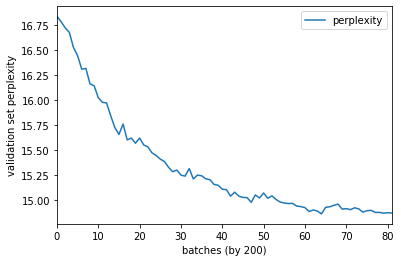

In [14]:
# plot perplexity. starts to overfit around 5 epochs

import pandas as pd
import matplotlib.pyplot as plt

! grep perplexity {finetuning_output} | \
perl -ne 'print "$$1\n" if /tensor\((\d+\.\d+)\)/' > perplexity.csv

perplexity = pd.read_csv("perplexity.csv", names=["perplexity"])
perplexity.plot()
plt.xlabel("batches (by 200)")
plt.ylabel("validation set perplexity")
plt.show()

In [15]:
import random

seed = random.randint(1,50000)
length = 500
prompt = "Once upon a time, Alice fell down a well, where she met a very curious rabbit."
! python transformers/examples/run_generation.py \
  --model_type=gpt2 \
  --model_name_or_path="./model" \
  --prompt="{prompt}" \
  --length={length} \
  --seed={seed}

12/02/2019 19:54:24 - INFO - transformers.tokenization_utils -   Model name './model' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming './model' is a path or url to a directory containing tokenizer files.
12/02/2019 19:54:24 - INFO - transformers.tokenization_utils -   loading file ./model/vocab.json
12/02/2019 19:54:24 - INFO - transformers.tokenization_utils -   loading file ./model/merges.txt
12/02/2019 19:54:24 - INFO - transformers.tokenization_utils -   loading file ./model/added_tokens.json
12/02/2019 19:54:24 - INFO - transformers.tokenization_utils -   loading file ./model/special_tokens_map.json
12/02/2019 19:54:24 - INFO - transformers.tokenization_utils -   loading file ./model/tokenizer_config.json
12/02/2019 19:54:24 - INFO - transformers.configuration_utils -   loading configuration file ./model/config.json
12/02/2019 19:54:24 - INFO - transformers.configuration_utils -   Model config {
  "attn_pdrop": 0.1,
  "embd_pdro

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_dir = "/content/drive/My Drive/Colab Notebooks/models/childrens-stories_fine-tuned_gpt2"
! rm -rf "{drive_dir}"
! mkdir "{drive_dir}"
! cp /content/model/*.json /content/model/*.txt /content/model/*.bin "{drive_dir}"

#Inference from Drive

In [0]:
drive_dir = "/content/drive/My Drive/Colab Notebooks/models/childrens-stories_fine-tuned_gpt2"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! pip install transformers

     |████████████████████████████████| 317kB 3.5MB/s 
     |████████████████████████████████| 860kB 42.5MB/s 
     |████████████████████████████████| 1.0MB 31.2MB/s 
     |████████████████████████████████| 645kB 36.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=d03a8e5ea483a34aa58360ec46602cb28295e1a4a9fc8445fb1ceb979353d671
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [0]:
! rm -rf transformers
# enhanced to use past with GPT-2
! git clone https://github.com/thisisrandy/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 12479 (delta 38), reused 52 (delta 30), pack-reused 12409
Receiving objects: 100% (12479/12479), 6.56 MiB | 20.47 MiB/s, done.
Resolving deltas: 100% (9130/9130), done.


In [0]:
import random

seed = random.randint(1,50000)
length = 1000
prompt = "Once upon a time, Alice fell down a well, where she met a very curious rabbit."
! python transformers/examples/run_generation.py \
  --model_type=gpt2 \
  --model_name_or_path="{drive_dir}" \
  --prompt="{prompt}" \
  --length={length} \
  --seed={seed}

11/24/2019 17:57:02 - INFO - transformers.tokenization_utils -   Model name '/content/drive/My Drive/Colab Notebooks/models/childrens-stories_fine-tuned_gpt2_1000' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, distilgpt2). Assuming '/content/drive/My Drive/Colab Notebooks/models/childrens-stories_fine-tuned_gpt2_1000' is a path or url to a directory containing tokenizer files.
11/24/2019 17:57:03 - INFO - transformers.tokenization_utils -   loading file /content/drive/My Drive/Colab Notebooks/models/childrens-stories_fine-tuned_gpt2_1000/vocab.json
11/24/2019 17:57:03 - INFO - transformers.tokenization_utils -   loading file /content/drive/My Drive/Colab Notebooks/models/childrens-stories_fine-tuned_gpt2_1000/merges.txt
11/24/2019 17:57:03 - INFO - transformers.tokenization_utils -   loading file /content/drive/My Drive/Colab Notebooks/models/childrens-stories_fine-tuned_gpt2_1000/added_tokens.json
11/24/2019 17:57:03 - INFO - transformers.tokenization_utils -  